# **Optimizing the JobTeaser Placement Funnel**

## **1. Introduction:**
### **Context:**
**JobTeaser** is a platform that connects students and companies by managing career services for over 750 universities globally. It provides a **matching tool** where companies can shortlist students for job opportunities. Optimizing the job placement funnel is critical to enhancing student employment rates and improving the platform's efficiency

### **Project goal:**
The goal of this project is to analyze and optimize the JobTeaser job placement funnel by identifying bottlenecks in the current process and suggesting improvements to increase student engagement and job matches.

### **Data Overview:**
This analysis uses three key datasets:
#### **Opt-in Table (optin):**
 Contains data about students opting in or out of JobTeaser services.

- **user_id:** ID of the student.
- **receive_time:** Date/time of opt-in/out.
- **cause:** Reason (manual or automatic).
- **active:** TRUE if opted in, FALSE if opted out.
- **school_id:** ID of the school.
- **current_sign_in_at:** Last login time.
- **resume_uploaded:** Whether the CV was uploaded.

#### **Candidate Status Update (candidate_status_update):**
Tracks students' status updates within the job application process.

- **user_id**: ID of the student.
- **receive_time**: Date/time of the event.
- **shortlist_id**: ID of the shortlist.
- **status_update**: Status (estudiante: `awaiting`, `interested`, `not interested`; empresa: `approved`, `declined`).
- **cause**: Reason (click or timeout).
- **school_id**: ID of the school.
- **current_sign_in_at**: Last login time.


#### **School Info Table (dim_schools):**
Provides data about the schools participating in JobTeaser's services.

- **school_id:** ID of the school.
- **is_cc:** Career center or public site.
- **intranet_school_id:** ID of the career center, if applicable.
- **jt_country:** Country of the school.
- **jt_intranet_status:** Status "launched" for career centers.
- **jt_school_type:** Type of school (1: Engineering, 2: Business, 3: Other).


## **2. Data Loading and Preparation:**

### **Library Imports:**

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from pycaret.classification import setup
from pycaret.classification import compare_models
from pycaret.classification import tune_model
from pycaret.classification import plot_model, evaluate_model
from pycaret.classification import save_model


### **Data Loading:**

In [2]:
df_optin = pd.read_csv('/content/optim_clean.csv')
df_candidate = pd.read_csv('/content/candidate_status_update_clean.csv')
df_school = pd.read_csv('/content/dim_schools_clean.csv')

### **Data Cleaning:**

In [3]:
# Removing unnecessary columns
df_optin.drop(columns='Unnamed: 0', inplace=True)
df_candidate.drop(columns='Unnamed: 0', inplace=True)
df_school.drop(columns='Unnamed: 0', inplace=True)

# Converting 'receive_time' and 'current_sign_in_at' columns to datetime format
df_optin['receive_time'] = pd.to_datetime(df_optin['receive_time'])
df_optin['current_sign_in_at'] = pd.to_datetime(df_optin['current_sign_in_at'])
df_candidate['receive_time'] = pd.to_datetime(df_candidate['receive_time'])
df_candidate['current_sign_in_at'] = pd.to_datetime(df_candidate['current_sign_in_at'])

## **3. Exploratory Data Analysis (EDA):**

### **Preliminary Funnel Analysis:**

In [4]:
# Stages of the funnel
stages = [
    'Total Users',           # Stage 1: All users in the system
    'Resume Uploaded',       # Stage 2: Users who uploaded their resume
    'Total Candidates',      # Stage 3: Total candidates (can include duplicates)
    'Users Answered',        # Stage 4: Users who clicked on an email and responded (interested or not interested)
    'Interested Users',      # Stage 5: Users marked as interested
    'Company Responded',     # Stage 6: Companies that responded (approved or declined, triggered by email click)
    'Approved Users'         # Stage 7: Users who have been approved
]

# Empty list to store user counts for each stage
counts = []

# Stage 1: All users in the system
total_users = df_optin['user_id'].nunique()
counts.append(total_users)

# Stage 2: Users who uploaded their resume
users_with_resume = df_optin[df_optin['resume_uploaded'] == True]['user_id'].nunique()
counts.append(users_with_resume)

# Stage 3: Total candidates (can include duplicates)
total_candidates = df_candidate['user_id'].count()
counts.append(total_candidates)

# Stage 4: Users who clicked on an email and responded (interested or not interested)
users_answered = df_candidate[
    (df_candidate['status_update'].isin(['interested', 'not interested'])) &
    (df_candidate['cause'] == 'email-click')
]['user_id'].count()
counts.append(users_answered)

# Stage 5: Users marked as interested
interested_users = df_candidate[df_candidate['status_update'] == 'interested']['user_id'].count()
counts.append(interested_users)

# Stage 6: Companies that responded (approved or declined, triggered by email click)
company_responded = df_candidate[
    (df_candidate['status_update'].isin(['approved', 'declined'])) &
    (df_candidate['cause'] == 'email-click')
]['user_id'].count()
counts.append(company_responded)

# Stage 7: Users who have been approved
approved_users = df_candidate[df_candidate['status_update'] == 'approved']['user_id'].count()
counts.append(approved_users)

# DataFrame with the stages and their corresponding user counts
df_stages = pd.DataFrame({
    'stage': stages,
    'count': counts
})




In [5]:
fig = px.funnel(df_stages, x='count', y='stage', color_discrete_sequence=['palegreen'])

fig.show()


### **Distribution of status updates:**

In [6]:
status_counts = df_candidate['status_update'].value_counts().rename_axis('status_update').reset_index(name='count')
fig = px.pie(status_counts, values='count', names='status_update', title='Status Distribution', color_discrete_sequence=px.colors.sequential.Greens_r[::2])
fig.show()


### **User count over time:**

In [7]:
df_optin['date'] = df_optin['receive_time'].dt.to_period('M')

monthly_activity = df_optin.groupby('date').size().reset_index(name='counts')

monthly_activity['date'] = monthly_activity['date'].astype(str)

fig = px.area(monthly_activity, x='date', y='counts', color_discrete_sequence=px.colors.sequential.RdPu_r[::2])
fig.show()

## **4. Preprocessing for Machine Learning:**

### **Model Strategy:**


####**Machine Learning Approach: Predicting Candidate Success**

This classification model aims to predict whether a candidate is likely to be approved based on historical data. Key points include:

**1. Multiple Status Updates:** Each candidate can have several entries in the Candidate table due to repeated evaluations, leading to various status updates like "approved" or "declined."

**2. Status Counting:** We count the occurrences of "approved" and "declined" statuses for each candidate to better understand their overall history.

**3. Approval Ratio:** This is calculated as the proportion of approvals to total evaluations. For example, a candidate with 3 approvals and 1 decline has an approval ratio of 0.75.

**4. Label Smoothing:** Instead of using strict labels (0 for declined and 1 for approved), we apply label smoothing to create a flexible labeling system. This maps the approval ratio to a range of [0.1, 0.9], reducing the risk of overfitting and improving the model's ability to handle uncertainties.

**5. Thresholds for Final Status:** Candidates with a smoothed label of 0.8 or higher are classified as "approved," while those with a label of 0.2 or lower are classified as "declined." Candidates in between are labeled as "neutral" and excluded from further analysis. This approach ensures that we only include candidates with strong evidence of approval or disapproval.




In [8]:
# Group by 'user_id' and count occurrences of each 'status_update'
counts = df_candidate.groupby('user_id')['status_update'].value_counts().unstack(fill_value=0)

# Map the count of 'approved' and 'declined' status to each 'user_id' in the df_candidate DataFrame
df_candidate['ApprovedCount'] = df_candidate['user_id'].map(counts['approved'])
df_candidate['DeclinedCount'] = df_candidate['user_id'].map(counts['declined'])

# Approval ratio
df_candidate['approval_ratio'] = df_candidate['ApprovedCount'] / (df_candidate['ApprovedCount'] + df_candidate['DeclinedCount'])

# Smoothing factor for label smoothing
label_smoothing_factor = 0.1

# Label smoothing, the smoothed labels are within the range [0.1, 0.9]
df_candidate['smoothed_label'] = df_candidate['approval_ratio'] * (1 - 2 * label_smoothing_factor) + label_smoothing_factor

# NaNs for rows with 0 approvals and 0 rejections
df_candidate['smoothed_label'] = df_candidate['smoothed_label'].fillna(0.5)

# Thresholds for labeling approved and declined
approval_threshold = 0.8
decline_threshold = 0.2

# New column 'final_status' to label approved/declined/neutral
df_candidate['final_status'] = np.where(
    df_candidate['smoothed_label'] >= approval_threshold, 'approved',
    np.where(df_candidate['smoothed_label'] <= decline_threshold, 'declined', 'neutral')
)
# Filter only the records with 'approved' or 'declined' in 'final_status'
df_candidate = df_candidate[df_candidate['final_status'].isin(['approved', 'declined'])]



In [9]:
df_candidate['final_status'].value_counts()

,count
final_status,
declined,2123
approved,1914


### **Feature Selection and Engineering:**

In [10]:
df_features = df_optin.groupby('user_id').agg(
    total_actions=('user_id', 'size'),  # Total actions per user_id
    first_action=('receive_time', 'min'),  # Date of the first action
    last_action=('receive_time', 'max'),  # Date of the last action
    active_actions=('active', lambda x: (x == True).sum()),  # Total active actions
    manual_actions=('cause', lambda x: (x == 'manual').sum()),  # Total manual actions
    auto_actions=('cause', lambda x: (x == 'auto-no answer').sum())  # Total automatic actions
).reset_index()

# Days between the first and last action
df_features['days_between_actions'] = (df_features['last_action'] - df_features['first_action']).dt.days

# Percentage of active actions
df_features['percentage_active_actions'] = df_features['active_actions'] / df_features['total_actions']

# Percentage of manual and automatic actions
df_features['percentage_manual_actions'] = df_features['manual_actions'] / df_features['total_actions']
df_features['percentage_auto_actions'] = df_features['auto_actions'] / df_features['total_actions']

# Merge with user_id and school_id to facilitate joining with the school table in subsequent operations
df_features= df_features.merge(df_optin[['user_id', 'school_id']].drop_duplicates(), on='user_id', how='left')

In [11]:
# Table with features, candidate table, and school table
df_final = df_features.merge(df_school, on='school_id', how='left')
df_final = df_candidate.merge(df_final, on='user_id', how='left')

In [12]:
df_final = df_final[['total_actions','days_between_actions','percentage_active_actions',
                     'percentage_manual_actions','percentage_auto_actions','is_cc','jt_school_type',
                     'jt_country','final_status']]

In [13]:
df_final = df_final.dropna()

# Encoding countries
le = LabelEncoder()
df_final['jt_country'] = le.fit_transform(df_final['jt_country'])

# 'is_cc' to integer type
df_final.loc[:, 'is_cc'] = df_final['is_cc'].astype(int)

df_final


,total_actions,days_between_actions,percentage_active_actions,percentage_manual_actions,percentage_auto_actions,is_cc,jt_school_type,jt_country,final_status
0,3.0,141.0,0.666667,0.666667,0.0,1,2.0,3,approved
1,3.0,184.0,0.666667,0.666667,0.0,1,3.0,3,approved
2,5.0,216.0,0.600000,1.000000,0.0,0,2.0,3,approved
3,7.0,107.0,0.571429,0.857143,0.0,1,3.0,4,approved
4,3.0,141.0,0.666667,0.666667,0.0,1,2.0,3,approved
...,...,...,...,...,...,...,...,...,...
4032,9.0,229.0,0.555556,0.555556,0.0,1,2.0,9,declined
4033,3.0,93.0,0.666667,0.666667,0.0,1,2.0,9,declined
4034,8.0,254.0,0.500000,0.875000,0.0,1,2.0,9,declined
4035,5.0,269.0,0.600000,0.600000,0.0,1,2.0,9,approved


### **Data Splitting:**

In [14]:
train, test = train_test_split(df_final
                               ,test_size=0.2
                               ,stratify=df_final['final_status']
                               ,random_state=42)

### **Encoding Categorical Features:**

In [15]:
cat_feature = ['jt_school_type']

train_cat = train[cat_feature]
test_cat = test[cat_feature]

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')

train_ohe = enc.fit_transform(train_cat)
test_ohe = enc.transform(test_cat)

train_cat_ohe = pd.DataFrame(train_ohe, columns=enc.get_feature_names_out(), index=train.index)
test_cat_ohe = pd.DataFrame(test_ohe, columns=enc.get_feature_names_out(), index=test.index)

train = train.drop(cat_feature, axis=1)
test = test.drop(cat_feature, axis=1)

train = pd.concat([train, train_cat_ohe], axis=1)
test = pd.concat([test, test_cat_ohe], axis=1)

### **Modeling:**

In [16]:
# Setting Up the PyCaret Environment
xp = setup(data = train,
           test_data = test,
           target = 'final_status',
           normalize = True,
           session_id = 42
           )

,Description,Value
0,Session id,42
1,Target,final_status
2,Target type,Binary
3,Target mapping,"approved: 0, declined: 1"
4,Original data shape,"(4035, 14)"
5,Transformed data shape,"(4035, 14)"
6,Transformed train set shape,"(3228, 14)"
7,Transformed test set shape,"(807, 14)"
8,Numeric features,12
9,Categorical features,1


In [17]:
# Model Comparison
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8324,0.9291,0.8324,0.8449,0.8298,0.6604,0.6745,0.4530
et,Extra Trees Classifier,0.8315,0.9334,0.8315,0.8438,0.8288,0.6585,0.6725,0.3870
dt,Decision Tree Classifier,0.8302,0.9262,0.8302,0.8426,0.8276,0.6560,0.6700,0.1130
xgboost,Extreme Gradient Boosting,0.8132,0.9106,0.8132,0.8257,0.8100,0.6213,0.6357,0.3200
lightgbm,Light Gradient Boosting Machine,0.8036,0.9034,0.8036,0.8145,0.8005,0.6020,0.6148,0.5960
knn,K Neighbors Classifier,0.7324,0.8353,0.7324,0.7367,0.7317,0.4649,0.4684,0.2040
gbc,Gradient Boosting Classifier,0.7200,0.7983,0.7200,0.7257,0.7158,0.4327,0.4412,0.3390
ada,Ada Boost Classifier,0.6431,0.6888,0.6431,0.6466,0.6362,0.2758,0.2834,0.3660
lr,Logistic Regression,0.5685,0.6006,0.5685,0.5694,0.5659,0.1342,0.1353,0.8940
lda,Linear Discriminant Analysis,0.5675,0.6007,0.5675,0.5683,0.5640,0.1312,0.1328,0.1030


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [18]:
# Model Tuning
best_model_tuned = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7307,0.8094,0.7307,0.7341,0.7279,0.4554,0.4610
1,0.7461,0.8249,0.7461,0.7576,0.7409,0.4844,0.4989
2,0.7090,0.8048,0.7090,0.7145,0.7045,0.4102,0.4187
3,0.7399,0.8273,0.7399,0.7441,0.7371,0.4740,0.4804
4,0.7152,0.7928,0.7152,0.7301,0.7069,0.4200,0.4389
5,0.6811,0.7815,0.6811,0.6841,0.6770,0.3543,0.3603
6,0.7183,0.8001,0.7183,0.7201,0.7161,0.4311,0.4348
7,0.7307,0.8177,0.7307,0.7349,0.7275,0.4550,0.4616
8,0.7205,0.8083,0.7205,0.7234,0.7179,0.4354,0.4404


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [19]:
# Since the original model outperformed the tuned model during hyperparameter optimization, it was selected for further evaluation
# Model Evaluation
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

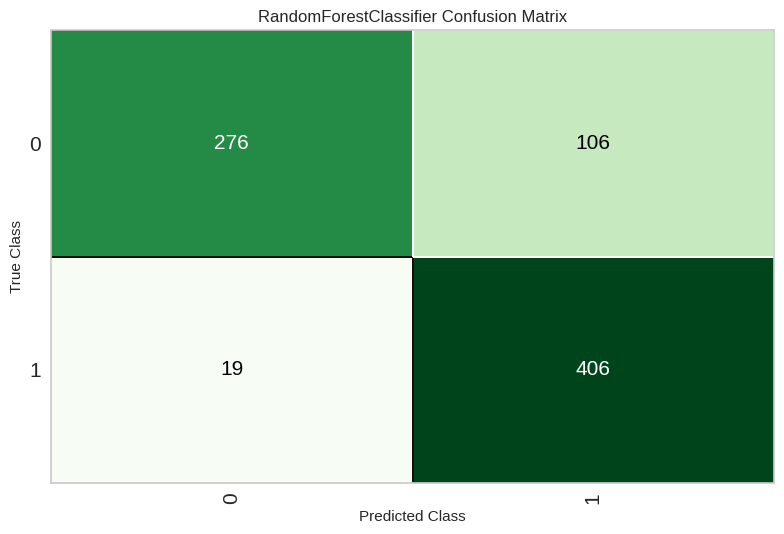

In [20]:
plot_model(best_model, plot="confusion_matrix")

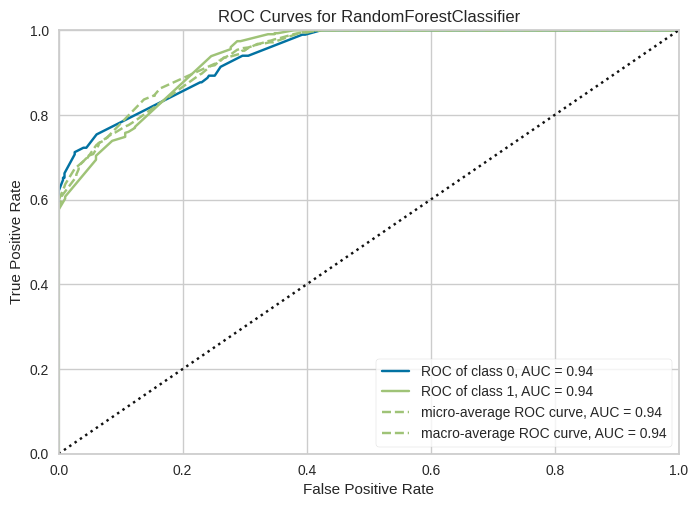

In [21]:
plot_model(best_model, plot="auc")

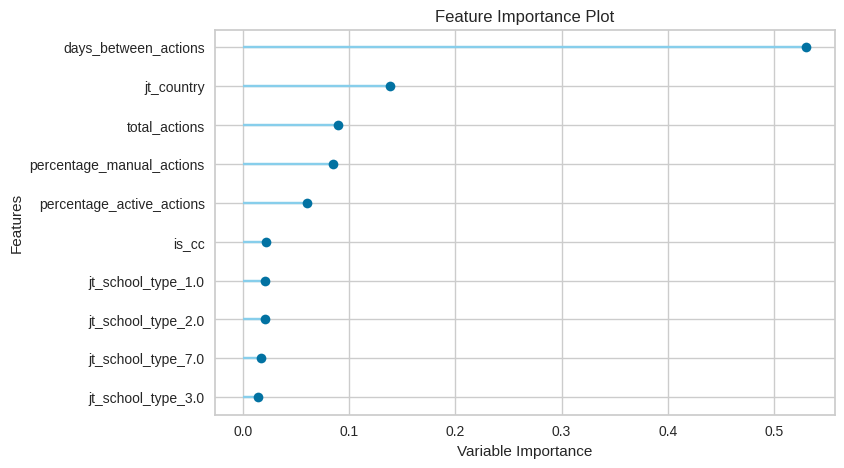

In [22]:
# Feature Importance Visualization
plot_model(best_model, plot = 'feature')

In [23]:
 # Model Saving
save_model(best_model_tuned, 'best_model_tuned')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['total_actions',
                                              'days_between_actions',
                                              'percentage_active_actions',
                                              'percentage_manual_actions',
                                              'percentage_auto_actions',
                                              'jt_country', 'jt_sc...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                          